Melakukan Import data

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

df = pd.read_csv("german_credit_data.csv")
df.columns = df.columns.str.strip()

Menghilangkan kolom yang tidak perlu

In [469]:
df = df.drop(columns=["Unnamed: 0"])

Data Exploration

In [470]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [472]:
df.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8
top,NaN,male,NaN,own,little,little,NaN,NaN,car
freq,NaN,690,NaN,713,603,274,NaN,NaN,337
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN


In [473]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

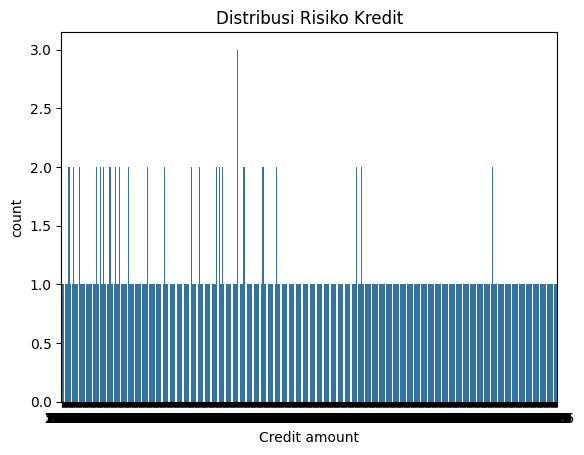

In [474]:
target_col = "Credit amount"
df[target_col] = df[target_col].astype(str)
sns.countplot(x=target_col, data=df)
plt.title("Distribusi Risiko Kredit")
plt.show()

Data Preparation

In [475]:
df["Credit amount"] = pd.to_numeric(df["Credit amount"], errors='coerce')
print(df["Credit amount"].isnull().sum())

0


In [476]:
df["Risk_binary"] = df["Credit amount"].apply(lambda x: "good" if x >= 10000 else "bad")

from sklearn.preprocessing import LabelEncoder
le_risk = LabelEncoder()
df["Risk_binary"] = le_risk.fit_transform(df["Risk_binary"])

print(df["Risk_binary"].value_counts())


Risk_binary
0    960
1     40
Name: count, dtype: int64


In [477]:
X = df.drop(columns=["Risk_binary"])
y = df["Risk_binary"]

In [478]:
categorical_cols = X.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [479]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

K-means Clustering

In [480]:
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

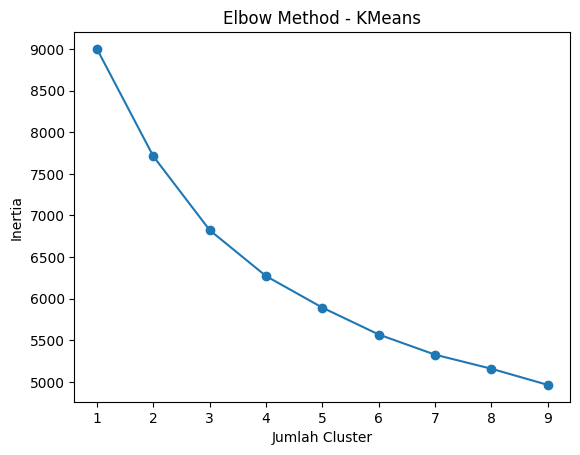

In [481]:
plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method - KMeans")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.show()

In [482]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Credit amount"] = kmeans.fit_predict(X_scaled)

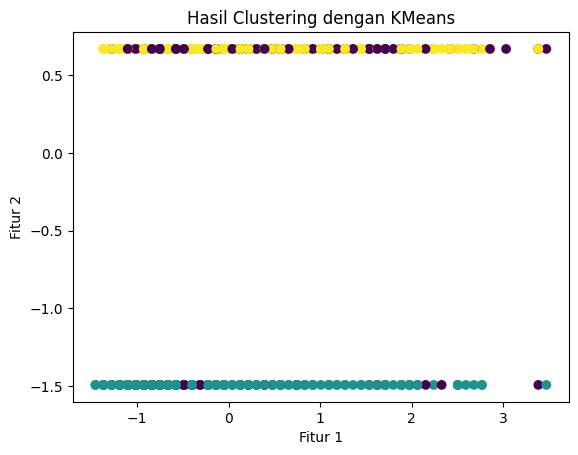

In [483]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df["Credit amount"], cmap='viridis')
plt.title("Hasil Clustering dengan KMeans")
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.show()

Logistic Regression

In [484]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [485]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [486]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

In [487]:
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Confusion Matrix:
[[196   0]
 [  0   4]]


In [488]:
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))


📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00         4

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [489]:
roc_score = roc_auc_score(y_pred, y_proba)
print(f"\n📈 ROC-AUC Score: {roc_score:.4f}")


📈 ROC-AUC Score: 1.0000


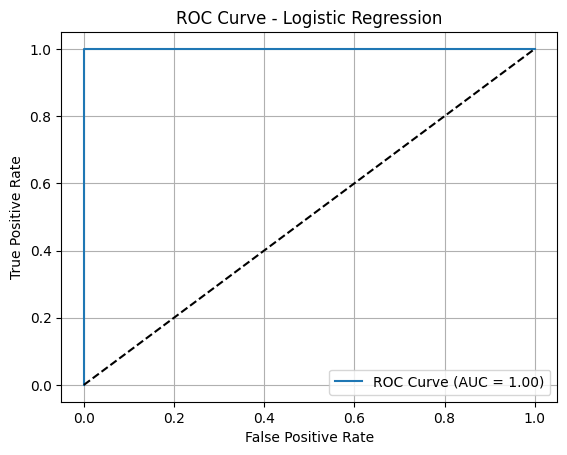

In [490]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()

Streamlit

In [491]:
# train_model.py
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dan bersihkan data
df = pd.read_csv("german_credit_data.csv")
df.columns = df.columns.str.strip()
df["Credit amount"] = pd.to_numeric(df["Credit amount"], errors='coerce')

# Buat target binary
df["Risk_binary"] = df["Credit amount"].apply(lambda x: "good" if x <= 10000 else "bad")
le = LabelEncoder()
df["Risk_binary"] = le.fit_transform(df["Risk_binary"])  # good=0, bad=1

# Fitur
X = df[["Age", "Job", "Credit amount", "Duration", "Housing"]]
y = df["Risk_binary"]

# Encode kategorik
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split & model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Simpan model dan scaler
with open("model_logreg.pkl", "wb") as f:
    pickle.dump(logreg, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model dan scaler berhasil disimpan.")


✅ Model dan scaler berhasil disimpan.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16588\545858893.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
